* NOTEBOOK: 03_data_preprocessing.ipynb
* DESCRIPTION: Hybrid Pipeline (Preprocessing + K-Means Clustering)


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import joblib
import os
import warnings

# 1. SETUP & WARNING SUPPRESSION

In [4]:
# Fix for "Downcasting" warnings in Pandas 2.0+
pd.set_option('future.no_silent_downcasting', True)
# Ignore other minor warnings for a clean presentation
warnings.filterwarnings("ignore")

# 2. LOAD THE DATASET

In [5]:
try:
    df = pd.read_csv('../data/medical_insurance_data.csv')
    print("Data Loaded Successfully!")
except FileNotFoundError:
    print("Error: File not found! Please check the path.")

Data Loaded Successfully!


# 2. VISUAL NULL CHECK

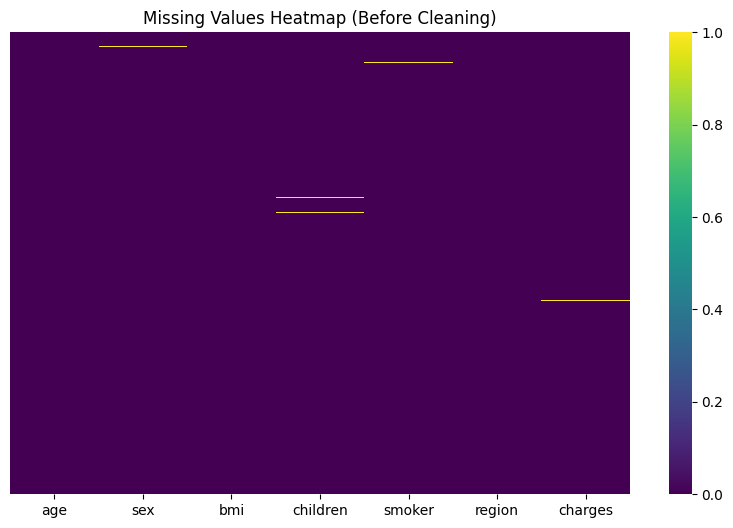

In [6]:
# Using a Heatmap to visualize missing data before cleaning.
# This shows exactly where the data is broken.
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), yticklabels=False, cbar=True, cmap='viridis')
plt.title("Missing Values Heatmap (Before Cleaning)")
plt.show()

# 3. DATA CLEANING (Handling Missing Values)

In [7]:
# Removing rows with missing data to ensure high model accuracy.
print(f"Original Dataset Size: {df.shape[0]} rows")
df_clean = df.dropna().reset_index(drop=True)
print(f"Cleaned Dataset Size:  {df_clean.shape[0]} rows (Missing values removed)")

Original Dataset Size: 2772 rows
Cleaned Dataset Size:  2736 rows (Missing values removed)


# 4. ADVANCED ENCODING

In [8]:
# A. Binary Encoding
# Mapping binary categorical features to 0 and 1.
df_clean['sex'] = df_clean['sex'].map({'male': 0, 'female': 1})
df_clean['smoker'] = df_clean['smoker'].map({'yes': 1, 'no': 0})

# B. One-Hot Encoding for Nominal Variables ('Region')
# We use One-Hot Encoding instead of Label Encoding to prevent the model 
# from assuming a mathematical order (e.g., Region 3 > Region 1), which does not exist.
region_dummies = pd.get_dummies(df_clean['region'], prefix='region', drop_first=True)

# Convert boolean values to integers (0/1) for compatibility
region_dummies = region_dummies.astype(int)

# Concatenate the new encoded columns and remove the original 'region' column
df_final = pd.concat([df_clean.drop('region', axis=1), region_dummies], axis=1)

print("\nData Sample after One-Hot Encoding:")
print(df_final.head())


Data Sample after One-Hot Encoding:
   age  sex     bmi  ...  region_northwest  region_southeast  region_southwest
0   19    1  27.900  ...                 0                 0                 1
1   18    0  33.770  ...                 0                 1                 0
2   28    0  33.000  ...                 0                 1                 0
3   33    0  22.705  ...                 1                 0                 0
4   32    0  28.880  ...                 1                 0                 0

[5 rows x 9 columns]


# 5. UNSUPERVISED LEARNING (K-Means Clustering)

In [9]:
# We use K-Means to find hidden patterns (clusters) in the data.
# This adds a new feature 'Cluster_Label' which helps in prediction.

print("\nRunning K-Means Clustering...")
# Using 3 clusters (based on Elbow method analysis)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)

# We use Age, BMI, and Charges to find clusters
cluster_data = df_final[['age', 'bmi', 'charges']].copy()

# Fit the model and predict clusters
df_final['Cluster_Label'] = kmeans.fit_predict(cluster_data)

# Save the K-Means model for future use
os.makedirs('../models', exist_ok=True)
joblib.dump(kmeans, '../models/kmeans_model.pkl')
print("✅ K-Means Model saved. 'Cluster_Label' added to dataset.")

print("\nData Sample with Clusters:")
print(df_final.head())


Running K-Means Clustering...
✅ K-Means Model saved. 'Cluster_Label' added to dataset.

Data Sample with Clusters:
   age  sex     bmi  ...  region_southeast  region_southwest  Cluster_Label
0   19    1  27.900  ...                 0                 1              0
1   18    0  33.770  ...                 1                 0              1
2   28    0  33.000  ...                 1                 0              1
3   33    0  22.705  ...                 0                 0              0
4   32    0  28.880  ...                 0                 0              1

[5 rows x 10 columns]


# 6. DATA SPLITTING (Train vs Test)

In [10]:
# X contains the Input Features (Age, BMI, Smoker, etc.)
# y contains the Target Variable (Insurance Charges)
X = df_final.drop('charges', axis=1)
y = df_final['charges']

# Using a fixed random_state to ensure reproducibility of results across the team.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# 7. FEATURE SCALING (Standardization)

In [11]:
# Scaling numerical features to standardize the range.
# This prevents features with larger magnitudes (e.g., Charges) from dominating the model.
scaler = StandardScaler()

# We scale only the continuous numerical columns
num_cols = ['age', 'bmi', 'children', 'Cluster_Label']
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Save the Scaler object for future deployment (Web App)
import os
os.makedirs('../models', exist_ok=True)
joblib.dump(scaler, '../models/scaler.pkl')
print("✅ Scaler saved to 'models' directory.")

✅ Scaler saved to 'models' directory.


# 8. SAVE PROCESSED DATA (Golden Data)

In [12]:
# Saving the processed files so all team members use the same data for modeling.
# Exporting the processed datasets for model training.
X_train.to_csv('../data/X_train.csv', index=False)
X_test.to_csv('../data/X_test.csv', index=False)
y_train.to_csv('../data/y_train.csv', index=False)
y_test.to_csv('../data/y_test.csv', index=False)

print("\n PHASE 3 COMPLETE: Processed Data Saved Successfully.")
print("The 'X_train.csv' and 'X_test.csv' files are ready for model building.")


 PHASE 3 COMPLETE: Processed Data Saved Successfully.
The 'X_train.csv' and 'X_test.csv' files are ready for model building.
